## Demo for crop image and infer landmark visibility

### Import SVI location csv and connect to existing image info

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
from pyproj import Transformer, Proj
import os
import glob
import shutil
import pandas as pd
from pyproj import Proj, transform
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

SVI_points_the_shard = gpd.read_file('data/global_metadata_SVI_cleaned/the_shard_3_km_svi_points_50m.gpkg').to_crs(27700)

# Convert central point to EPSG:27700 projection
central_lat = 51.50462497710506
central_lon = -0.08652726915106525
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)
central_x, central_y = transformer.transform(central_lon, central_lat)
central_point = Point(central_x, central_y)
SVI_points_the_shard['distance_to_the_shard'] = SVI_points_the_shard.geometry.distance(central_point)
image_path_id_df = SVI_points_the_shard.copy()[:5000]

In [5]:
image_path_id_df .columns = ['index', 'Unnamed: 0', 'image_id', 'pano_lat', 'pano_lon', 'heading',
       'roll', 'pitch', 'sampling_lat', 'sampling_lon', 'location',
       'image_path', 'index_right', 'landmark', 'geometry',
       'distance_to_the_shard']

/data/zicheng/.conda/envs/torch_cuda_118/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/data/zicheng/.conda/envs/torch_cuda_118/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_1673414/3004959227.py:15: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-f

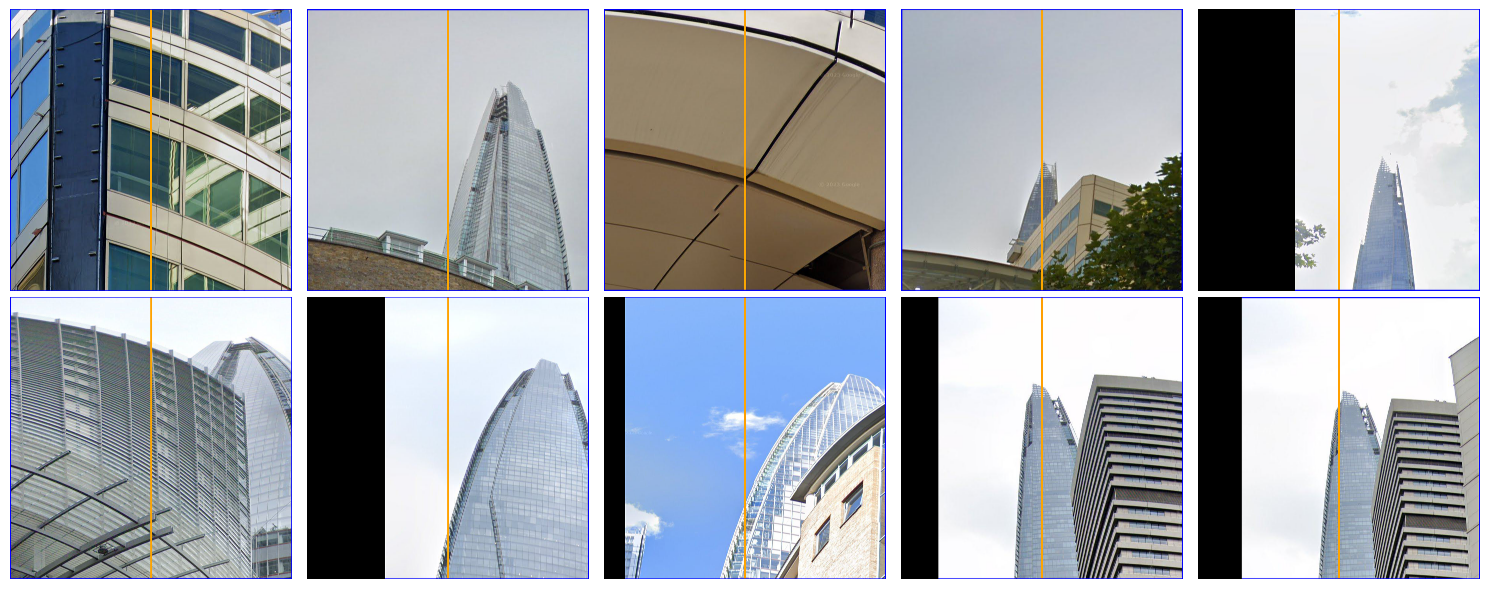

In [6]:
# Import required libraries
import geopandas as gpd
import numpy as np
from pyproj import Proj, transform
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Define the landmark's central point coordinates (latitude and longitude)
central_lat = 51.50462497710506
central_lon = -0.08652726915106525

# Define coordinate transformer: from WGS84 (EPSG:4326) to British National Grid (EPSG:27700)
proj_transform = Proj(init='epsg:4326'), Proj(init='epsg:27700')

# Convert central point coordinates to EPSG:27700 projection
central_point_transformed_x, central_point_transformed_y = transform(proj_transform[0], proj_transform[1], central_lon, central_lat)
central_point_transformed = Point(central_point_transformed_x, central_point_transformed_y)

# Helper function to calculate line endpoint
def calculate_endpoint(start_point, angle_rad, distance):
    """
    Calculate the endpoint of a line given start point, angle and distance
    Args:
        start_point: Starting point coordinates
        angle_rad: Angle in radians
        distance: Distance
    Returns:
        Endpoint coordinates (x, y)
    """
    dx = distance * np.sin(angle_rad)
    dy = distance * np.cos(angle_rad)
    return start_point.x + dx, start_point.y + dy

# Get data and filter 10 images within 300m of the landmark
data = image_path_id_df
sample_images_10 = data[data.distance_to_the_shard<300].reset_index()[:10]

# Create 2x5 image display layout
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Process each image
for i in range(len(sample_images_10)):
    # Get current image ID
    image_id_to_search = sample_images_10.image_id[i]
    
    # Get observation point info from dataframe
    obs_point_info = data[data['image_id'] == image_id_to_search].iloc[0]
    obs_point = obs_point_info['geometry']
    obs_heading = obs_point_info['heading']
    
    # Calculate direction angle from observation point to central point
    dy_central = central_point_transformed.y - obs_point.y
    dx_central = central_point_transformed.x - obs_point.x
    angle_to_central = np.arctan2(dx_central, dy_central)
    
    # Open and process panoramic image
    image_path = obs_point_info.image_path
    image = Image.open(image_path)
    image_width, image_height = image.size
    
    # Create drawing object
    draw = ImageDraw.Draw(image)
    
    # Draw heading line (green vertical line)
    heading_line_start = (image_width / 2, 0)
    heading_line_end = (image_width / 2, image_height)
    draw.line([heading_line_start, heading_line_end], fill=(0, 255, 0), width=5)
    
    # Draw central line (orange vertical line showing direction to central point)
    angle_to_central_degrees = np.degrees(angle_to_central)
    heading_degrees = np.degrees(obs_heading)
    angle_difference = (angle_to_central_degrees - heading_degrees) % 360
    central_line_x_position_from_center = (image_width / 2) + (angle_difference / 360) * image_width
    central_line_x_position_from_center = central_line_x_position_from_center % image_width
    
    central_line_start_from_center = (central_line_x_position_from_center, 0)
    central_line_end_from_center = (central_line_x_position_from_center, image_height)
    draw.line([central_line_start_from_center, central_line_end_from_center], fill=(255, 165, 0), width=5)

    # Landmark height in meters （extra spacing is applied)
    landmark_height = 500  # meters
    
    # Observer's distance to landmark in meters
    distance_to_landmark = sample_images_10.distance_to_the_shard[i]
    
    # Calculate elevation angle in radians
    angle_of_elevation = np.arctan(landmark_height / distance_to_landmark)
    
    # Calculate vertical field of view parameters
    vertical_field_of_view_degrees = 180
    vertical_field_of_view_radians = np.radians(vertical_field_of_view_degrees)
    vertical_radians_per_pixel = vertical_field_of_view_radians / image_height
    vertical_pixel_extent = angle_of_elevation / vertical_radians_per_pixel
    vertical_center = image_height / 2

    # Calculate crop box coordinates
    upper = vertical_center - vertical_pixel_extent
    lower = vertical_center
    
    left = central_line_x_position_from_center - (abs(vertical_pixel_extent))/3
    right = central_line_x_position_from_center + (abs(vertical_pixel_extent))/3
    
    # Draw initial crop box (red)
    draw.rectangle([left, upper, right, lower], outline="red", width=3)

    # Calculate zoomed crop box coordinates
    upper_zoom_in = upper
    lower_zoom_in = lower - 0.5*vertical_pixel_extent
    right_zoom_in = central_line_x_position_from_center + (abs(upper_zoom_in - lower_zoom_in))/2
    left_zoom_in = central_line_x_position_from_center - (abs(upper_zoom_in - lower_zoom_in))/2
    
    # Draw zoomed crop box (blue)
    draw.rectangle([left_zoom_in, upper_zoom_in, right_zoom_in, lower_zoom_in], outline="blue", width=3)
    
    # Crop and zoom image
    draw_box = [left_zoom_in, upper_zoom_in, right_zoom_in, lower_zoom_in]
    cropped_image = image.crop(draw_box)
    zoom_factor = 10
    new_size = (int((draw_box[2] - draw_box[0]) * zoom_factor), int((draw_box[3] - draw_box[1]) * zoom_factor))
    zoomed_image = cropped_image.resize(new_size, Image.LANCZOS)
   
    # Display zoomed image in subplot
    axes[i].imshow(zoomed_image)
    axes[i].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [7]:
sample_images_10

,level_0,index,Unnamed: 0,image_id,pano_lat,pano_lon,heading,roll,pitch,sampling_lat,sampling_lon,location,image_path,index_right,landmark,geometry,distance_to_the_shard
0,47,16407,16407,uR3-c1LQq1adB5sbCwuV-A,51.506380,-0.083890,0.113622,0.012899,-0.001027,51.506355,-0.083896,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (533078.836 180345.578),267.671617
1,491,16990,16990,HxE-HMVf9zK8RPsZO7TTkQ,51.503897,-0.088911,4.579388,0.013364,-0.012355,51.503890,-0.088915,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (532737.626 180060.280),184.245663
2,1343,18092,18092,dZhc4DPl6VwyyAXrwrr8gA,51.506422,-0.084334,1.650891,6.282440,0.047248,51.506443,-0.084310,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (533047.915 180349.365),251.259971
3,1344,18093,18093,hYztpAnZKjW4CceMxnO8mQ,51.506551,-0.084743,1.822103,6.230271,0.069417,51.506731,-0.084686,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (533019.164 180362.948),247.441519
4,1345,18094,18094,uI54gb2_j2K--XFLR2dK_g,51.505823,-0.089911,5.117991,0.012075,0.028227,51.505569,-0.089898,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (532662.608 180272.653),270.091407
5,1863,18839,18839,FgXOsWyPJdD1GfdjvngdPQ,51.504503,-0.087644,5.293107,6.261717,0.003963,51.504487,-0.087612,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (532823.762 180129.949),78.742485
6,1864,18840,18840,dLYWfzOh0IRIYRAvQvpkQA,51.503666,-0.087727,3.632714,0.048610,0.019426,51.503637,-0.087784,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (532820.429 180036.761),135.361395
7,1865,18841,18841,_eakbQ0YJbnqRNGJpJQqOg,51.504008,-0.087455,3.574830,0.081688,0.098140,51.503981,-0.087489,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (532838.350 180075.285),94.118570
8,1866,18842,18842,ioOKFoP3pwBE5zpguc9TGg,51.502936,-0.088180,3.451594,6.225041,0.016568,51.502979,-0.088187,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (532791.156 179954.806),220.104289
9,1867,18843,18843,wB6fROjdt9uQZNHlIxxxTA,51.502850,-0.088225,3.456885,6.244908,0.018206,51.502797,-0.088072,London,/data/zicheng/2024_summer_ism/data/global_svi_...,0,the_shard,POINT (532788.267 179945.081),229.986683


### Connect the cropped images to OWL-VIT model

In [8]:
from transformers import pipeline

checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [9]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

/data/zicheng/.conda/envs/torch_cuda_118/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/data/zicheng/.conda/envs/torch_cuda_118/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_1673414/2804911103.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-f

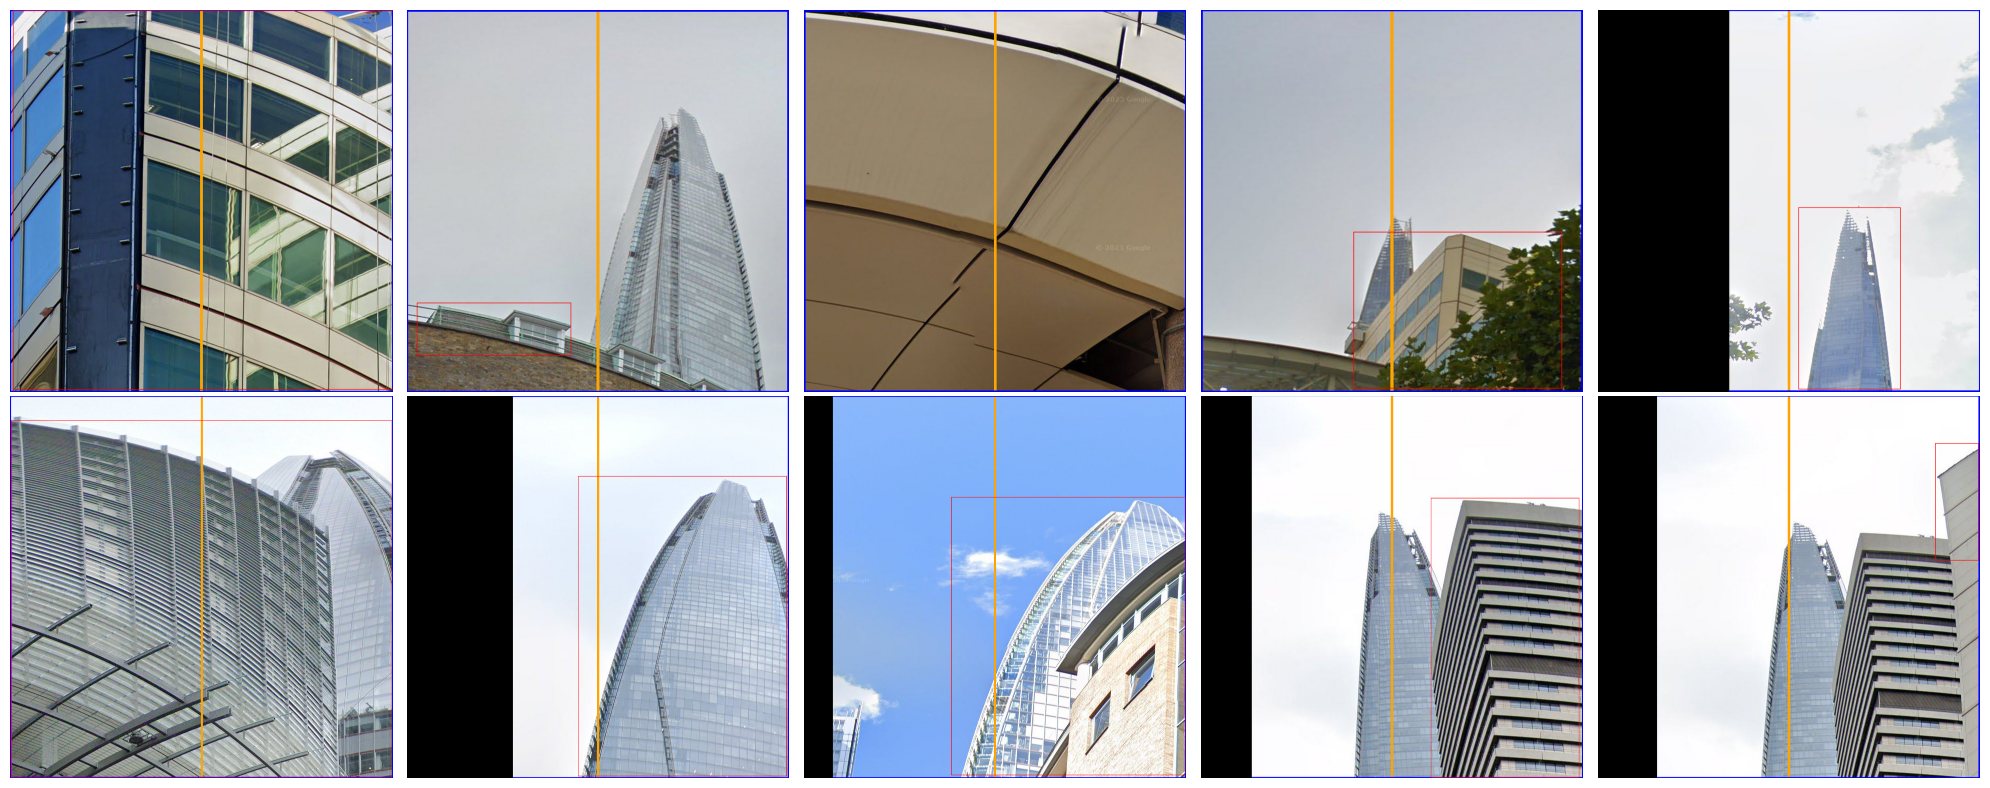

In [13]:
import geopandas as gpd
import numpy as np
from pyproj import Proj, transform
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import requests
import torch

# Define the central point in latitude and longitude
central_lat = 51.50462497710506
central_lon = -0.08652726915106525

# Define the projection transformation
proj_transform = Proj(init='epsg:4326'), Proj(init='epsg:27700')

# Convert central point coordinates to EPSG:27700
central_point_transformed_x, central_point_transformed_y = transform(proj_transform[0], proj_transform[1], central_lon, central_lat)
central_point_transformed = Point(central_point_transformed_x, central_point_transformed_y)

# Function to calculate endpoint of a line given a start point, distance, and angle
def calculate_endpoint(start_point, angle_rad, distance):
    dx = distance * np.sin(angle_rad)
    dy = distance * np.cos(angle_rad)
    return start_point.x + dx, start_point.y + dy

data = image_path_id_df
# Calculate relative radians for each observation point

sample_images_10 = data[data.distance_to_the_shard<300].reset_index()[:10]
results_data = []

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(len(sample_images_10)):
    image_id_to_search = sample_images_10.image_id[i]
    
    # Using the image_id from the filename to find the observation point in the dataframe
    obs_point_info = data[data['image_id'] == image_id_to_search].iloc[0]
    obs_point = obs_point_info['geometry']
    obs_heading = obs_point_info['heading']
    
    # Calculate the direction to the central point
    dy_central = central_point_transformed.y - obs_point.y
    dx_central = central_point_transformed.x - obs_point.x
    angle_to_central = np.arctan2(dx_central, dy_central)
    
    # Annotating the panoramic image
    image_path = obs_point_info.image_path
    image = Image.open(image_path)
    image_width, image_height = image.size
    
    draw = ImageDraw.Draw(image)
    
    # Heading line (vertical line in the center)
    heading_line_start = (image_width / 2, 0)
    heading_line_end = (image_width / 2, image_height)
    draw.line([heading_line_start, heading_line_end], fill=(0, 255, 0), width=5)
    
    # Central line (vertical line representing the direction to the central point)
    angle_to_central_degrees = np.degrees(angle_to_central)
    heading_degrees = np.degrees(obs_heading)
    angle_difference = (angle_to_central_degrees - heading_degrees) % 360
    central_line_x_position_from_center = (image_width / 2) + (angle_difference / 360) * image_width
    central_line_x_position_from_center = central_line_x_position_from_center % image_width
    
    central_line_start_from_center = (central_line_x_position_from_center, 0)
    central_line_end_from_center = (central_line_x_position_from_center, image_height)
    draw.line([central_line_start_from_center, central_line_end_from_center], fill=(255, 165, 0), width=5)

    # The landmark's height (in meters)
    landmark_height = 500  # meters
    distance_to_landmark = sample_images_10.distance_to_the_shard[i]
    angle_of_elevation = np.arctan(landmark_height / distance_to_landmark)
    
    vertical_field_of_view_degrees = 180
    vertical_field_of_view_radians = np.radians(vertical_field_of_view_degrees)
    vertical_radians_per_pixel = vertical_field_of_view_radians / image_height
    vertical_pixel_extent = angle_of_elevation / vertical_radians_per_pixel
    vertical_center = image_height / 2
    
    top_pixel_position = vertical_center - vertical_pixel_extent 
    bottom_pixel_position = vertical_center

    upper = top_pixel_position
    lower = bottom_pixel_position 
    
    left = central_line_x_position_from_center - (abs(vertical_pixel_extent))/3
    right = central_line_x_position_from_center + (abs(vertical_pixel_extent))/3
    
    draw.rectangle([left, upper, right, lower], outline="red", width=3)

    upper_zoom_in = upper + 0.2*vertical_pixel_extent
    lower_zoom_in = lower - 0.5*vertical_pixel_extent
    
    right_zoom_in = central_line_x_position_from_center + (abs(upper_zoom_in - lower_zoom_in))/2
    left_zoom_in = central_line_x_position_from_center - (abs(upper_zoom_in - lower_zoom_in))/2
    draw.rectangle([left_zoom_in, upper_zoom_in, right_zoom_in, lower_zoom_in], outline="blue", width=3)
    
    draw_box = [left_zoom_in, upper_zoom_in, right_zoom_in, lower_zoom_in]
    cropped_image = image.crop(draw_box)
    
    zoom_factor = 9
    new_size = (int((draw_box[2] - draw_box[0]) * zoom_factor), int((draw_box[3] - draw_box[1]) * zoom_factor))
    zoomed_image = cropped_image.resize(new_size, Image.LANCZOS)
    
    image_target = Image.fromarray(np.uint8(zoomed_image)).convert("RGB")
    query_image = Image.open('data/London_50m_svi_view_points/query_images/the_shard_1_a.png', mode='r')
    query_image = Image.fromarray(np.uint8(query_image)).convert("RGB")
    
    inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model.image_guided_detection(**inputs)
        target_sizes = torch.tensor([image_target.size[::-1]])
        results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.5, target_sizes=target_sizes)[0]

    detected = results["scores"].numel() > 0 and results["scores"][0] > 0.5
    boxes = results["boxes"].tolist()[:1] if detected else []
    scores = results["scores"].tolist()[:1] if detected else []
    
    results_data.append({
        "image_id": image_id_to_search,
        "image_path": image_path,
        "boxes": boxes,
        "scores": scores,
        "detected": detected
    })
    
    draw = ImageDraw.Draw(image_target)
    
    for box, score in zip(boxes, scores):
        xmin, ymin, xmax, ymax = box
        draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=10)
    
    # Display in the subplot
    axes[i].imshow(image_target)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Convert results list to a DataFrame
results_df = pd.DataFrame(results_data)

### infer for all images with single/multi - quiery images

In [31]:
import geopandas as gpd
import numpy as np
from pyproj import Proj, transform
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import requests
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm 

# Define the central point in latitude and longitude
central_lat = 51.50462497710506
central_lon = -0.08652726915106525

# Define the projection transformation
proj_transform = Proj(init='epsg:4326'), Proj(init='epsg:27700')

# Convert central point coordinates to EPSG:27700
central_point_transformed_x, central_point_transformed_y = transform(proj_transform[0], proj_transform[1], central_lon, central_lat)
central_point_transformed = Point(central_point_transformed_x, central_point_transformed_y)

# Function to calculate endpoint of a line given a start point, distance, and angle
def calculate_endpoint(start_point, angle_rad, distance):
    dx = distance * np.sin(angle_rad)
    dy = distance * np.cos(angle_rad)
    return start_point.x + dx, start_point.y + dy

data = image_path_id_df


query_image1 = Image.open('data/London_50m_svi_view_points/query_images/the_shard_1_a.png').convert("RGB")
query_image2 = Image.open('data/London_50m_svi_view_points/query_images/the_shard_2_a.png').convert("RGB")  # already existing
query_image3 = Image.open('data/London_50m_svi_view_points/query_images/the_shard_3_a.png').convert("RGB")

#sample_images_10 = data[(data. distance_to_the_shard>300) & (data. distance_to_the_shard<400)].reset_index()
#sample_images_10 = data[(data.distance_to_the_shard<400) & (data.distance_to_the_shard>200)].reset_index()
sample_images_10 = data[(data.distance_to_the_shard<1000)].reset_index()
sample_images_10 = data[(data.distance_to_the_shard<2000)].reset_index()
results_data = []

for i in tqdm(range(len(sample_images_10 ))):
    image_id_to_search = sample_images_10.image_id[i]
    
    # Using the image_id from the filename to find the observation point in the dataframe
    obs_point_info = data[data['image_id'] == image_id_to_search].iloc[0]
    obs_point = obs_point_info['geometry']
    obs_heading = obs_point_info['heading']
    
    # Calculate the direction to the central point
    dy_central = central_point_transformed.y - obs_point.y
    dx_central = central_point_transformed.x - obs_point.x
    angle_to_central = np.arctan2(dx_central, dy_central)
    
    # Annotating the panoramic image
    image_path = obs_point_info.image_path
    image = Image.open(image_path)
    image_width, image_height = image.size
    
    draw = ImageDraw.Draw(image)
    
    # Central line (vertical line representing the direction to the central point)
    angle_to_central_degrees = np.degrees(angle_to_central)
    heading_degrees = np.degrees(obs_heading)
    angle_difference = (angle_to_central_degrees - heading_degrees) % 360
    central_line_x_position_from_center = (image_width / 2) + (angle_difference / 360) * image_width
    central_line_x_position_from_center = central_line_x_position_from_center % image_width

    # The landmark's height (in meters)
    landmark_height = 500  # meters
    distance_to_landmark = sample_images_10.distance_to_the_shard[i]   
    # Calculate the angle of elevation (in radians)
    angle_of_elevation = np.arctan(landmark_height / distance_to_landmark)
    

    vertical_field_of_view_degrees = 180  # Just an estimate, actual value may vary
    vertical_field_of_view_radians = np.radians(vertical_field_of_view_degrees)
    # Calculate the vertical radians per pixel
    vertical_radians_per_pixel = vertical_field_of_view_radians / image_height

    
    # Calculate the vertical pixel extent of the landmark from the center of the image
    vertical_pixel_extent = angle_of_elevation / vertical_radians_per_pixel
    vertical_center = image_height / 2  # Assuming the horizon is at the vertical center of the image
    # Calculate the top and bottom pixel positions for the landmark in the image
    # We assume that the observer is looking straight ahead at the horizon, so the bottom of the landmark is at the center
    # The top is then 'vertical_pixel_extent' pixels above the bottom
    top_pixel_position =   vertical_center - vertical_pixel_extent 
    bottom_pixel_position = vertical_center  # Bottom is at the horizon level

    upper = top_pixel_position
    lower = bottom_pixel_position 
    # Draw a red rectangle around the estimated landmark position
    # Define the size of the rectangle
    left =central_line_x_position_from_center - (abs( vertical_pixel_extent))/3
    right = central_line_x_position_from_center+ (abs( vertical_pixel_extent))/3
    
    # Re-draw the rectangle on the image with the new vertical bounds
    # We'll reuse the left and right bounds from the previous rectangle for the horizontal position
    draw.rectangle([left, upper, right, lower], outline="red", width=3)


    upper_zoom_in =  upper+0.2*vertical_pixel_extent
    lower_zoom_in = lower - 0.5*vertical_pixel_extent
    right_zoom_in = central_line_x_position_from_center + (abs( upper_zoom_in -  lower_zoom_in ))/2
    left_zoom_in = central_line_x_position_from_center -(abs( upper_zoom_in -  lower_zoom_in ))/2
    draw.rectangle([left_zoom_in, upper_zoom_in , right_zoom_in, lower_zoom_in], outline="blue", width=3)
    
    # Assuming draw_box represents the rectangle you want to crop and zoom in on
    draw_box =[left_zoom_in, upper_zoom_in , right_zoom_in, lower_zoom_in]  # Replace with your actual box coordinates

    # Crop the image using the defined box
    cropped_image = image.crop(draw_box)

    # Optionally, resize to zoom in, e.g., double the size of the cropped area
    zoom_factor = 9
    new_size = (int((draw_box[2] - draw_box[0]) * zoom_factor), int((draw_box[3] - draw_box[1]) * zoom_factor))
    zoomed_image = cropped_image.resize(new_size, Image.LANCZOS)
    
    image_target= Image.fromarray(np.uint8(zoomed_image)).convert("RGB")
   
    
    #query_images = [query_image1, query_image2, query_image3]
    query_images = [query_image2]
    query_results = []
    images_for_plotting = []
    for query_image in query_images:
        inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")
        with torch.no_grad():
            outputs = model.image_guided_detection(**inputs)
            target_sizes = torch.tensor([image_target.size[::-1]])
            results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.7, target_sizes=target_sizes)[0]
    
        detected = results["scores"].numel() > 0 and results["scores"][0] > 0.7
        boxes = results["boxes"].tolist()[:1] if detected else []
        scores = results["scores"].tolist()[:1] if detected else []
    
        results_data.append({
            "image_id": image_id_to_search,
            "query_image_index": len(images_for_plotting) - 1,  # Index in the query_images list
            "boxes": boxes,
            "scores": scores,
            "detected": detected
        })
    

C:\Users\zicheng\.conda\envs\tf-gpu\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\zicheng\.conda\envs\tf-gpu\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\zicheng\AppData\Local\Temp\ipykernel_3736\1016194386.py:21: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-

In [36]:
results_df = pd.DataFrame(results_data)
results_df = SVI_points_the_shard[['geometry','image_id','distance_to_the_shard']].merge(results_df)
results_df.to_csv('data/London_50m_svi_view_points/inference_result/0422_inference_result.csv')

In [38]:
#results_df = pd.read_csv('data/London_50m_svi_view_points/inference_result/0422_inference_result.csv')
#results_df['geometry'] = gpd.GeoSeries.from_wkt(results_df['geometry'])

results_gdf = gpd.GeoDataFrame(results_df, geometry='geometry')
results_gdf= results_gdf.merge(SVI_points_the_shard[['image_id','distance_to_the_shard']])
results_gdf[results_gdf.boxes!= '[]']['distance_to_the_shard'].max()

2998.67485016965

### Visualize the inference results

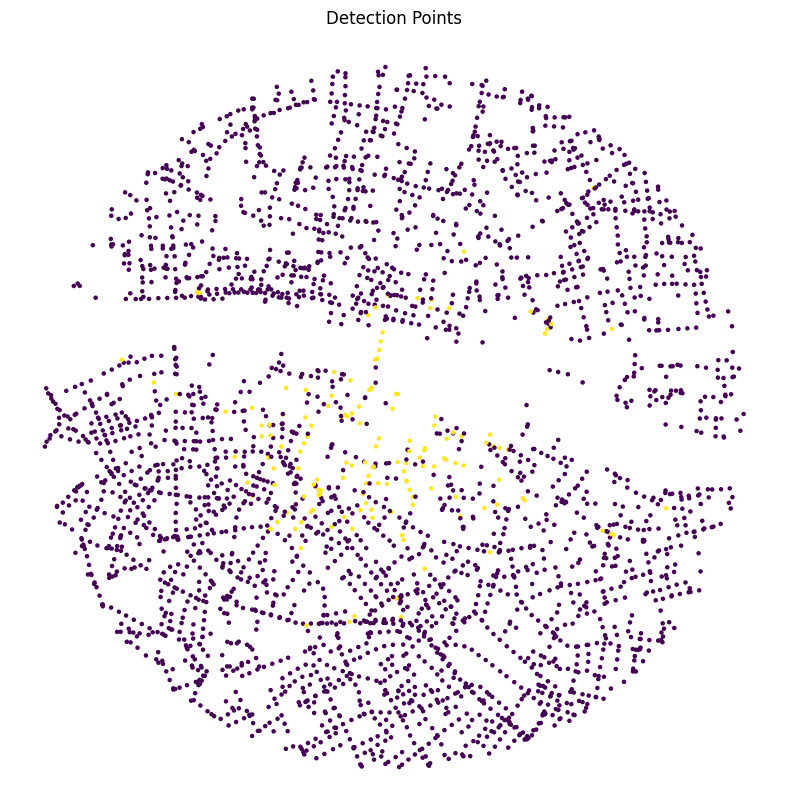

153


In [45]:
results_gdf.loc[results_gdf.detected==True,'color_id'] = 1
results_gdf.loc[results_gdf.detected==False,'color_id'] = 0
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plotting
results_gdf[results_gdf.distance_to_the_shard<2000].plot(ax=ax, column= 'color_id', markersize=5)

ax.set_title('Detection Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Removing axis for cleaner look
ax.set_axis_off()

plt.show()
print(len(results_gdf[results_gdf.color_id!= 0]))